# Test Execution Analysis

## I) Introduction :

Pharo is a pure object-oriented programming language and a powerful environnement. <br>
Pharo's tools are in constant evolution and new builds are created almost everyday.<br> 
Each time a new build is created, pharo runs all the tests to ensure its good inner working.<br> 
However there are some tests that seem to randomly throw errors for unclear reasons. <br>
Those tests are called flaky tests.  
The purpose of this project is to find an order with the analysis of test statistics and the use of machine learning to try  
to predict which tests could be flaky in order to improve the time spend on a build that won't be accepted because of an unexpected error.

## II) Extracting information from a Package result file :

For each execution of a package a result file like the one attached is generated.<br>
This File includes information about each executed test.<br>
We have the time to execute the test and the results.<br>
Also if there is an error there is the exception that generated it.<br>
The idea is to extract the information from this file. Tests-windows-64-Zinc-Tests-Test.xml<br>

In [2]:
import pandas as pd

For this first step, I used a website to convert this xml into a csv.

In [3]:
data = pd.read_csv("Datasets/Test_Zinc.csv", sep=',', header=0, encoding = "ISO-8859-1", engine='python')

Test_Zinc is a set of informations concerning the tests of the Zinc package after running them on a Windows 64 OS.  
It contains 221 tests and 6 types of information.

In [4]:
data.shape

(221, 6)

There is the name of the tests' class, the name of the test, the time of execution and the informations about the failure if there was one. 

In [5]:
data.head()

_classname                 _name  \
0  Windows64.Zinc.Tests.ZnBivalentWriteStreamTest       testByteWriting   
1  Windows64.Zinc.Tests.ZnBivalentWriteStreamTest  testCharacterWriting   
2        Windows64.Zinc.Tests.ZnChunkedStreamTest   testBinaryWriteRead   
3        Windows64.Zinc.Tests.ZnChunkedStreamTest     testGzipWriteRead   
4        Windows64.Zinc.Tests.ZnChunkedStreamTest           testReading   

   _time failure/_type failure/_message failure/__text  
0  0.000           NaN              NaN            NaN  
1  0.000           NaN              NaN            NaN  
2  0.000           NaN              NaN            NaN  
3  5.764           NaN              NaN            NaN  
4  0.000           NaN              NaN            NaN

In [6]:
data.dropna()

_classname                      _name   _time  \
28  Windows64.Zinc.Tests.ZnClientTest  testIfFailNonExistingHost  10.035   

   failure/_type  failure/_message  \
28   TestFailure  Assertion failed   

                                       failure/__text  
28  TestFailure\r\nAssertion failed\r\nZnClientTes...

I have made a jupyter notebook with some statistics : Test_Zinc_Statistics.ipypd

The idea, now is to combine every package from a build in a single dataframe.

## III) Gathering Data :

### 1) Study of the potentialy useful informations :

The following exemples show the basis of what a test is. You create variables then test or use global variables to test the results of messages. 

|||
| --- | --- |
| 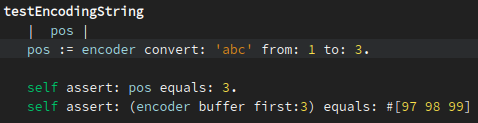 | 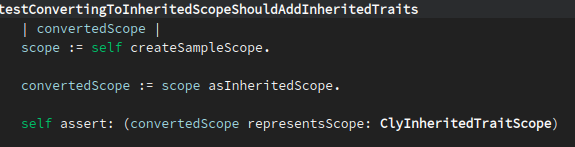 |

##### 1. Informations for Statistics :

Since most of the tests come from previous builds, we can use the data to schedule them.  
The idea, if there is an error in the tests, is to make it append as early as possible to lose less time.  
The first tests to run should be the new/changed tests then the flaky ones and finaly those which have to most chance to fail but the smallest running time.  

##### 2. Informations for Flaky tests :

We want to know which test could be flaky tests. That is why I had to think about what, in the test, could make it unstable.  
The first thing I thought of was the number of lines. Because the bigger the test, the bigger the chance to introduce instability.  
The second is the number of global variables used. Global variables can produce unexpected errors because the value can be changed by an other test previously run.  
The third us the number of différent classes used. My idea is that weird interactions could emerge from using to many classes.  
The same applies to messages and local variables being that the more there are, the more instability could be introduced.  

Finaly, to decide if a test is flaky or not, we can't use the time of the test (nor the error message) because the idea is to spot potential flaky tests before testing them.

### 2) Test duration :

Pharo uses Jenkins to run the tests and store the data. It is kept in XML files accessible with a URL.  
There is an XML containing the link to the last 10 builds' XML. A build's XML contains the local paths to the packages' XML (like the one above).  
In the beginning, I was considering going through all the builds and have the mean time of every test ever run.  
The probleme was that the dataframe created was too heavy and after 200 builds max, a size error was thrown.  
That is why I finaly decided to settle for 2 different dataframes :  
The first one contains the informations about a specific build and the second one contains the informations about every failed tests.  
I, therefore, created a pyhon file with a class that can easily create and update those dataframes : BuildsToDataset.py  

In [7]:
data_build = pd.read_csv("Build_1248.csv", sep=',', header=0, encoding = "ISO-8859-1", engine='python')

In [8]:
data_build.head()

Unnamed: 0                                         @classname  \
0           0  MacOSX64.Announcements.Core.Tests.Tests.Announ...   
1           1  Unix64.Collections.Unordered.Tests.Dictionarie...   
2           2  Unix64.Collections.Unordered.Tests.Dictionarie...   
3           3  Unix64.Collections.Unordered.Tests.Dictionarie...   
4           4  Unix64.Collections.Unordered.Tests.Dictionarie...   

                                               @name     @time  \
0                                testIncludeOnlyOnce  0.000024   
1                                     testDifference  0.000025   
2          testDictionaryPublicProtocolCompatibility  0.000055   
3       testDictionaryConcatenationWithoutCommonKeys  0.000007   
4  testDictionaryConcatenationWithCommonKeysDiffe...  0.000021   

                      @package  @time_min  @time_max  nb_builds  
0     Announcements-Core-Tests        0.0      0.004      837.0  
1  Collections-Unordered-Tests        0.0      0.002      710.0  
2  Collections-Unordered-Tests        0.0      0.005      710.0  
3  Collections-Unordered-Tests        0.0      0.003      710.0  
4  Collections-Unordered-Tests        0.0      0.005      710.0

@time -> the mean of all the testing times (1 for each build)  
@nb_builds -> the number of builds the test was in  
@time_min -> the lowest testing time  
@time_max -> the highest testing time  
@classname -> the name of the class and the context in which the test was run in  
@package -> the name of the package  
@name -> the name of the test (selector)  
Unnamed: 0 is the indexation (not useful)

In [9]:
data_error = pd.read_csv("Error_dataframe.csv", sep=',', header=0, encoding = "ISO-8859-1", engine='python')

In [10]:
data_error.head()

Unnamed: 0  Unnamed: 0.1  \
0           0         174.0   
1           1           8.0   
2           2          23.0   
3           3          23.0   
4           4          23.0   

                                          @classname  \
0                   MacOSX32.Zinc.Tests.ZnServerTest   
1  Unix32.Glamour.Tests.Rubric.GLMRubricTextMorph...   
2  MacOSX32.System.Settings.Tests.SystemSettingsP...   
3  Unix32.System.Settings.Tests.SystemSettingsPer...   
4  Windows32.System.Settings.Tests.SystemSettings...   

                                               @name  @time  \
0                           testFormTest3Unspecified  2.384   
1  testInitializeBlockSetsTextSelectionForTextPre...  0.786   
2             testDefaultImageDoesNotStoreAnySetting  0.252   
3             testDefaultImageDoesNotStoreAnySetting  0.370   
4             testDefaultImageDoesNotStoreAnySetting  0.241   

                @package                                            failure  \
0             Zinc-Tests  OrderedDict([('@type', 'TestFailure'), ('@mess...   
1   Glamour-Tests-Rubric                                                NaN   
2  System-Settings-Tests  OrderedDict([('@type', 'TestFailure'), ('@mess...   
3  System-Settings-Tests  OrderedDict([('@type', 'TestFailure'), ('@mess...   
4  System-Settings-Tests  OrderedDict([('@type', 'TestFailure'), ('@mess...   

   build                                              error  
0   13.0                                                NaN  
1   14.0  OrderedDict([('@type', 'SubscriptOutOfBounds')...  
2   16.0                                                NaN  
3   16.0                                                NaN  
4   16.0                                                NaN

@time -> the testing times  
build -> the build the error append in  
failure -> the cause of the failure  
error -> the cause of the error  
remaining is unchanged

###### The class that constructs these kind of dataframes :  

get_builds(self):  
Returns a list of all the Pharo 9.0 builds by taking the last build from the jenkins xml file and going from 2 to said build.  
It begins at 2 because 0 doesn't exist and 1 is empty. 

get_xml_from_build(self,build):  
build : the url of the build you want to extract  
Returns the list of all the xml url present in the given build  

get_database_from_xml(self,build,xml):  
build : the url of the build you want to extract 
xml : the local path of the file you want to get 
Returns the dataframe the tests from all the given xml classes of given build 

get_all_database_from_build(self,build):  
build : the url of the build you want to extract  
Returns the complete dataframe with all the tests from all the builds  

get_error_database_from_build(self,build):  
build : the url of the build you want to extract  
Return the dataframe of all the tests which had an error/failure in given build.  
If there was none, then it returns an empty dataframe.

get_errors_df(self):  
Returns the dataframe containing all the errors/failures present in jenkin's database of builds.  
get_errors_df_from_to(self, f, t):  
f : the number of the build you want to begin at   
t : the number of the build you want to end at   
f < t   
Returns the dataframe containing the errors/failures present in jenkin's database of builds from one build to another.  

append(self, df1, df2, name=None):  
df1 : the main pandas dataframe   
df2 : the pandas dataframe you want to append   
name : string of the path of the file you want to save the dataframe on (optional)   
Returns a dataframe with the rows of df2 added to the ones of df1.  
The variable name is there if you want to save the datafreame on a file.  

append_errordf(self, df2):   
df2 : the pandas dataframe you want to append   
Returns a dataframe with the rows of df2 added to the ones of Error_dataframe.csv.   
The new dataframe is then stored in Error_dataframe.csv   

get_full_df(self):  
Returns the dataframe of the last build with a time that is a mean of all times from all builds.  

full_df_from(self, number, csv=None):  
number : the number of the build you want the means of  
csv : string of the path of the file you want to save the dataframe on (optional)  
Returns the dataframe of the given build with a time that is a mean of all times from all previous builds.  

full_df_from_to(self,f,t, csv=None):  
f : the number of the build you want the means of  
t : the number of the build you want to stop at  
f > t  
csv : string of the path of the file you want to save the dataframe on (optional)  
Returns the dataframe of the given build with a time that is a mean of all times from previous builds, stopping at the given build.  

merge_left(self, df1, df2, csv= None):  
df1 : the left pandas dataframe   
df2 : the right pandas dataframe   
csv : string of the path of the file you want to save the dataframe on (optional)  
Returns a dataframe where the mean time has been calculated and the number of presence in builds incremented  

get_usable_df(self, build):  
build : the url of the build you want to extract  
Return the dataframe prepared to be used for mean time dataframe.  

##### This part put a problem in light with the files contained in the Jenkins XML.  
There are test that are run multiple times (same @classname, @name, @package but different @time).  
I noticed it when trying to merge builds together. Duplications appeared and made the dataframe grow exponentialy.  
So I took the decision to take the highest completion time into account because a lot of the test are completed are completed in '0.0' seconds.  
which means that the resluts potentialy does not match with the time passed on the test but the precision of the float.  

### 3) Code Statistics :

I couldn't do this part myself because of access permissions to the gitlab.

In [12]:
data_build_statistics = pd.read_csv("Build_1248_With_Statistics.csv", sep=',', header=0, encoding = "ISO-8859-1", engine='python')

In [13]:
data_build_statistics.head()

Unnamed: 0     PackageName          ClassName                selector  \
0           0  AST-Core-Tests  ASTEvaluationTest            testEvaluate   
1           1  AST-Core-Tests  ASTEvaluationTest            testEvaluate   
2           2  AST-Core-Tests  ASTEvaluationTest            testEvaluate   
3           3  AST-Core-Tests  ASTEvaluationTest            testEvaluate   
4           4  AST-Core-Tests  ASTEvaluationTest  testEvaluateForContext   

                                          sourceCode  numberOfGlobalsUsed  \
0  testEvaluate\r\tself assert: (RBLiteralNode va...                    0   
1  testEvaluate\r\tself assert: (RBLiteralNode va...                    0   
2  testEvaluate\r\tself assert: (RBLiteralNode va...                    0   
3  testEvaluate\r\tself assert: (RBLiteralNode va...                    0   
4  testEvaluateForContext\r\t| varForTesting node...                    0   

   numberOfClassesUsed  numberOfMessagesUsed  numberOfLocalVariables  lines  \
0                    2                     6                       0      3   
1                    2                     6                       0      3   
2                    2                     6                       0      3   
3                    2                     6                       0      3   
4                    1                    12                       2     21   

          @classname                   @name     @time        @package  \
0  ASTEvaluationTest            testEvaluate  0.000900  AST-Core-Tests   
1  ASTEvaluationTest            testEvaluate  0.001922  AST-Core-Tests   
2  ASTEvaluationTest            testEvaluate  0.001121  AST-Core-Tests   
3  ASTEvaluationTest            testEvaluate  0.002131  AST-Core-Tests   
4  ASTEvaluationTest  testEvaluateForContext  0.018162  AST-Core-Tests   

   @time_min  @time_max  nb_builds        @os  
0      0.000      0.005     1047.0     Unix64  
1      0.000      0.045      837.0   MacOSX64  
2      0.000      0.213      942.0     Unix32  
3      0.000      0.053      954.0  Windows64  
4      0.003      0.116      837.0   MacOSX64

In [14]:
data_error_statistics = pd.read_csv("Error_Dataframe_With_Statistics.csv", sep=',', header=0, encoding = "ISO-8859-1", engine='python')

In [15]:
data_error_statistics.head()

Unnamed: 0                     @classname  \
0           0                   ZnServerTest   
1           1       GLMRubricTextMorphicTest   
2           2  SystemSettingsPersistenceTest   
3           3  SystemSettingsPersistenceTest   
4           4  SystemSettingsPersistenceTest   

                                               @name  @time  \
0                           testFormTest3Unspecified  2.384   
1  testInitializeBlockSetsTextSelectionForTextPre...  0.786   
2             testDefaultImageDoesNotStoreAnySetting  0.252   
3             testDefaultImageDoesNotStoreAnySetting  0.370   
4             testDefaultImageDoesNotStoreAnySetting  0.241   

                @package                                            failure  \
0             Zinc-Tests  OrderedDict([('@type', 'TestFailure'), ('@mess...   
1   Glamour-Tests-Rubric                                                NaN   
2  System-Settings-Tests  OrderedDict([('@type', 'TestFailure'), ('@mess...   
3  System-Settings-Tests  OrderedDict([('@type', 'TestFailure'), ('@mess...   
4  System-Settings-Tests  OrderedDict([('@type', 'TestFailure'), ('@mess...   

   build                                              error        @os  \
0     13                                                NaN   MacOSX32   
1     14  OrderedDict([('@type', 'SubscriptOutOfBounds')...     Unix32   
2     16                                                NaN   MacOSX32   
3     16                                                NaN     Unix32   
4     16                                                NaN  Windows32   

                                          sourceCode  numberOfGlobalsUsed  \
0  testFormTest3Unspecified\r\t"Simulate what mos...                  0.0   
1  testInitializeBlockSetsTextSelectionForTextPre...                  0.0   
2  testDefaultImageDoesNotStoreAnySetting\r\t| no...                  0.0   
3  testDefaultImageDoesNotStoreAnySetting\r\t| no...                  0.0   
4  testDefaultImageDoesNotStoreAnySetting\r\t| no...                  0.0   

   numberOfClassesUsed  numberOfMessagesUsed  numberOfLocalVariables  lines  
0                  4.0                  21.0                     4.0   23.0  
1                  0.0                   1.0                     0.0    3.0  
2                  3.0                   6.0                     1.0   11.0  
3                  3.0                   6.0                     1.0   11.0  
4                  3.0                   6.0                     1.0   11.0

## IV) Clustering of the Source Code :

The idea of putting tests into clusters was to divide them by type of tests. 

Studying the code, I found that, package per package, you can separate the tests into clusters but packages can go from over 50 test to less than 5.  
Furthermore, I don't find any interest in clustering by package.  

For a global clustering, this is way more complicated and I didn't have the time to search a way to do it.  
The idea I had was to only keep local variables and messages. The problem is that local variables can be name however we want.  But they often carry the meaning so we could find a way to analyse the code to extract the meaning and then classify the tests.

## V) Statistics :

I made a jupyter notebook showing some of the statistics in the build 1248 : Statistics_On_Build_1248.ipynb

The total time of test execution could go from 1780 (best case scenario) seconds to 16450 (worst case scenario) but the mean time is around 3800 seconds.  

The shortest tests can take a fraction of a second to complete but the longest test can take up to 430 seconds.  

Concerning packages :

In averge, it is the package "Tests" that takes up the most time.  
-> "Tests", "Refactoring-Tests-Core", "Spec2-Backend-Tests", "Refactoring-Tests-Environment", "Refactoring2-Transformations-Tests", "ReleaseTests", "GT-Tests-Spotter-Processors" take up, in average, half the testing time.  

The packages above are sorted in a decreasing time order. This order changes when taking the minimum and the maximum time. Some packages are stable and stay around the same position like "Refactoring-Tests-Core". Which should be tested towards the end because they take up the most time and they are the less suceptible to contain falky test (that could throw an error).  

Other packages could be put before because they might contain unidentified flaky tests like "Kernel-Tests" which doesn't appear in the longest times for mean and minimum but is the longest for maximum. As errors increase the testing time, this implies that this package might produce unexpected errors.  

The packages that have the most errors/failures are "ReleaseTests", "Zinc-Tests", "Taskit-Tests", "Kernel-Tests", "System-Settings-Tests", "Hiedra-Tests", "NECompletion-Tests", "Tests". Those represent around 2/3 of the total number of error/failures from build 1 to build 1248.

## VI) Detection of flaky tests :

I tried finding flaky tests with Deep Learning but the results where not successful : Flaky_tests.ipynb  
As expected with the data, since there are too few errors in the builds to have a good prediction score but the confusion matrix shows many false positive and few false negative: more than 50% of the tests that are identified as flaky are not flaky.  For me, this is not a real problem as we just want to prioritise flaky tests false positives are not a problem.  
We will just prioritise test that are going to be run anyway.

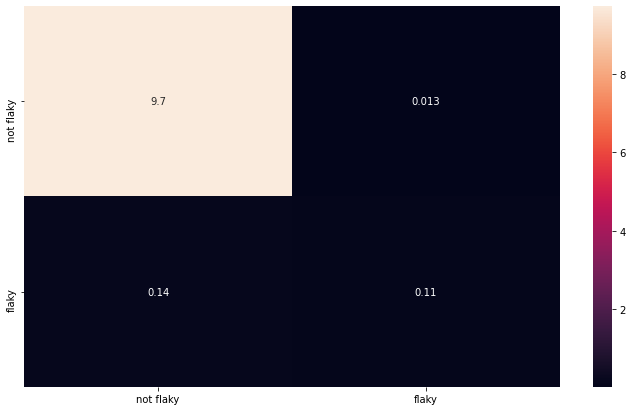

## VII) Conclusion :

In conclusion, I think we could upgrade the flaky test detection with a clustering of the source code but the result shows a suffisient prediction rate of the flaky tests. Now, I think that the following step is finding a way to weigh the test between the probability they have to be flaky and the time they take to realise a scheduling that would minimise the time spend on a build with an error.  